## SALSA Clump UV Background Clump-Labeling Issues

In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as sp
import pickle
from mpi4py import MPI
import yt
import trident
import salsa
from salsa.utils import check_rays

/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


### Running SALSA Pipeline

Here, I give a breif overview as to how we obtain our SALSA data using pre-generated ray data.

To begin with, we start by loading in the halo data from FOGGIE that we would be using

In [2]:
# specifying which halo we are looking at and at what redshift
halo = 2392
rs = 20

halo_path = f"/mnt/research/galaxies-REU/sims/FOGGIE/halo_00{halo}/nref11c_nref9f/RD00{rs}/RD00{rs}"

halo_data = yt.load(halo_path)

yt : [INFO     ] 2023-09-12 22:28:03,802 Parameters: current_time              = 154.80100926529
yt : [INFO     ] 2023-09-12 22:28:03,803 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-09-12 22:28:03,803 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-09-12 22:28:03,804 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-09-12 22:28:03,804 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-09-12 22:28:03,805 Parameters: current_redshift          = 2
yt : [INFO     ] 2023-09-12 22:28:03,805 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-09-12 22:28:03,805 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-09-12 22:28:03,805 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-09-12 22:28:03,806 Parameters: hubble_constant           = 0.695


Now I create the rays that we will be using. To do so, we must first do a bit of preprocessing on the FOGGIE data to put the data into a more readable format. Additionally, this will also require the use of a local instalation of FOGGIE to access the information on the halo that we are looking at. This can be done by editing the following block of code.

In [3]:
# EDIT THIS CELL 
foggie_dir = "/mnt/home/tairaeli/astro_libs/foggie/foggie/halo_infos"

Once the above step is completed, the following cell should run without any errors

In [4]:
center_dat = {}

# loading in FOGGIE data
raw_foggie_dat = pd.read_csv(f"{foggie_dir}/00{halo}/nref11c_nref9f/halo_c_v", sep = '|', 
                             names = ['null','redshift','name','xc','yc','zc','xv','yv','zv','null2'])

# making some fixes specific to these files
raw_foggie_dat = raw_foggie_dat.drop(0)
raw_foggie_dat = raw_foggie_dat.drop(columns = ['null','null2'])

# isolating data to a specific redshift 
raw_foggie_dat = raw_foggie_dat[raw_foggie_dat['name'] == ' RD00'+str(rs)+' ']

# storing the position and velocity data of the galactic center
center_dat['pos'] = [float(raw_foggie_dat["xc"]),float(raw_foggie_dat["yc"]),float(raw_foggie_dat["zc"])]
center_dat['vel'] = [float(raw_foggie_dat["xv"]),float(raw_foggie_dat["yv"]),float(raw_foggie_dat["zv"])]

Now, we deifine some more parameters. Typically these would be stored inside of a parameter file, but to keep things all in one place, they have been defined within the cell below

In [5]:
# input fields as they appear in parameter file
field_items = "density temperature metallicity radius".split(" ")
field_types = "gas NA NA index".split(" ")
units = "g/cm**3 NA Zsun NA".split(" ")

# converting parameters from a string to a dictionary to make SALSA happy
field_units = {}
other_fields = []
for i, item in enumerate(field_items):
    
    if field_types[i] == "NA":
        field_tup = item
    else:
        field_tup = (field_types[i],item)
        
    other_fields.append(field_tup)
    
    if units[i] == "NA":
        continue
    else:
        field_units[f"{item}"] = units[i]

After defining a few more variables, we are finally ready to create our rays

In [6]:
# defining features about calaxy center
center = halo_data.arr(center_dat['pos'], 'kpc')
gal_vel = halo_data.arr(center_dat['vel'], 'km/s')

# defining characteristics of ray behavior
nrays = 1
max_impact = 15

out_path = "./"

# defining random seed to allow for repitition
np.random.seed(13)

# creating rays and saving results
salsa.generate_lrays(halo_data, 
                     center.to('code_length'), 
                     nrays, 
                     max_impact, 
                     length=600, 
                     field_parameters={'bulk_velocity':gal_vel}, 
                     ion_list=['H I'], 
                     fields=other_fields, 
                     out_dir=out_path)

Parsing Hierarchy :   0%|          | 0/15873 [00:00<?, ?it/s]

Parsing Hierarchy : 100%|██████████| 15873/15873 [00:02<00:00, 6491.87it/s]
yt : [INFO     ] 2023-09-12 22:28:20,257 Gathering a field list (this may take a moment.)
yt : [WARNING  ] 2023-09-12 22:28:21,561 Field ('gas', 'H_p0_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2023-09-12 22:28:21,562 Field ('gas', 'H_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2023-09-12 22:28:21,562 Field ('gas', 'H_p0_density') already exists. Not clobbering.
yt : [WARNING  ] 2023-09-12 22:28:21,562 Field ('gas', 'H_density') already exists. Not clobbering.
yt : [WARNING  ] 2023-09-12 22:28:21,563 Field ('gas', 'H_p0_mass') already exists. Not clobbering.
yt : [WARNING  ] 2023-09-12 22:28:21,563 Field ('gas', 'H_mass') already exists. Not clobbering.
yt : [INFO     ] 2023-09-12 22:28:21,576 Getting segment at z = 2: [0.50381313 0.49882155 0.4787564 ] unitary to [0.49201615 0.49507428 0.48057005] unitary.
yt : [INFO     ] 2023-09-12 22:28:21,578 Getting subsegment:

Once the dataset has been loaded in, and the rays have been created, we can set our desired UV Background. In this code, I use the UV Background from Puchwein et al. 2019, but the same process can be followed with the other UVB that is analyzed from Haart & Madau 2012. All that needs to be changed is the respective file path.

In [7]:
# ray name not especially important here, but useful for when there are multiple rays
ray = 0

# defining data about the particular ascpects of the rays we are looking at
ion = "O VI"
atom,istate = ion.split(" ")

field_name = f"{atom}_p{trident.from_roman(istate)-1}_number_density"

# defines abundance table used
# CHANGE THESE TO LOCAL VERSIONS
abun_table_path = "/mnt/home/tairaeli/trident_uncertainty/mods/abundances/scripts/abun_table.txt"
abun = pd.read_csv(abun_table_path, delim_whitespace=True)
abundances = abun.iloc[0].to_dict()

# defines UVB being used (Puchwein et al, 2019)
# CHANGE THESE TO LOCAL VERSIONS
uvb = "/mnt/home/tairaeli/trident_uncertainty/mods/abundances/data_bin/par_test.h5"
# uvb = "/mnt/home/tairaeli/trident_uncertainty/mods/abundances/data_bin/hm2012_ss_hr.h5"

uvb_name = "PCW_2019"

ray_filename = f"ray{ray}.h5"

ray_dat = yt.load(ray_filename)

trident.add_ion_number_density_field(atom, trident.from_roman(istate), 
                                     ray_dat, abundance_dict = abundances, 
                                     ionization_table = uvb)

# extracting data from ray analysis
pcw_dens = ray_dat.r[("gas",field_name)].copy()

# pickl = open("./hm_dens.pickle","wb")
# pickle.dump(pcw_dens, pickl, protocol=3)
# pickl.close()

# saving general ray data to variables
ray_len_cm = ray_dat.domain_width.to("cm")[0]
n_cells = len(pcw_dens)

ray_pos = np.linspace(0,ray_len_cm,n_cells)

yt : [INFO     ] 2023-09-12 22:29:00,274 Parameters: current_time              = 154.80100926529 code_time
yt : [INFO     ] 2023-09-12 22:29:00,275 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2023-09-12 22:29:00,275 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2023-09-12 22:29:00,276 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2023-09-12 22:29:00,276 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-09-12 22:29:00,277 Parameters: current_redshift          = 2
yt : [INFO     ] 2023-09-12 22:29:00,278 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-09-12 22:29:00,278 Parameters: omega_matter              = 0.285
yt : [ERROR    ] 2023-09-12 22:29:00,278 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2023-09-12 22:29:00,279 Parameters: hubble_constant           = 0.695
yt : [INFO     ] 2023-09-12 22:29:00,332 Allocating for 8.350e+02 particle

Buckle up bc we're about to get wRIGGITY WRIGGITY WRECKED SON


For the sake of simplicity (as well as avoiding a strange quirk with yt when it comes to setting UVBs), the results of the Haart and Madau UVB has already been saved to a pickle file.

In [8]:
with open("./hm_dens.pickle", "rb") as dens_dat:
    hm_dens = pickle.load(dens_dat)

Now, given some abudnance table, we use SALSA to identify where the gas clumps are within our ray for each UVB (also showing this process for only the Puchwein UVB)

In [11]:
# a bit more prep before the absorber extraction step
comm = MPI.COMM_WORLD

ray_list=[ray_filename]

# CK: Taking a hint from SALSA on how to divvy up the ray list across procs
# works under assumption we have multiple rays, but in this case we do not
ray_arr = np.array(ray_list)
ray_files_split = np.array_split(ray_arr, comm.size)
my_rays = ray_files_split[comm.rank]

abs_ext = salsa.AbsorberExtractor(halo_data, 
                                  ray_filename, 
                                  ion_name = ion, 
                                  velocity_res =20, 
                                  abundance_table = abundances, 
                                  calc_missing=True)

# mimicing how data is stored in code
pcw_clump_dat = {ion:{uvb_name:None}}

pcw_clump_dat[ion][uvb_name] = salsa.get_absorbers(abs_ext, 
                                my_rays, 
                                method='spice', 
                                fields=other_fields, 
                                units_dict=field_units)

pcw_clump_dat[ion][uvb_name] = pcw_clump_dat[ion][uvb_name].drop(columns='index')

# ponkle = open("./hm_absorbers.pickle","wb")
# pickle.dump(pcw_clump_dat, ponkle, protocol=3)
# ponkle.close()

yt : [INFO     ] 2023-09-12 22:34:57,006 Parameters: current_time              = 154.80100926529 code_time
yt : [INFO     ] 2023-09-12 22:34:57,006 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2023-09-12 22:34:57,007 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2023-09-12 22:34:57,008 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2023-09-12 22:34:57,008 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-09-12 22:34:57,008 Parameters: current_redshift          = 2
yt : [INFO     ] 2023-09-12 22:34:57,009 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-09-12 22:34:57,009 Parameters: omega_matter              = 0.285
yt : [ERROR    ] 2023-09-12 22:34:57,010 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2023-09-12 22:34:57,011 Parameters: hubble_constant           = 0.695
yt : [INFO     ] 2023-09-12 22:34:57,065 Allocating for 8.350e+02 particle

Buckle up bc we're about to get wRIGGITY WRIGGITY WRECKED SON


/mnt/home/tairaeli/.local/lib/python3.6/site-packages/yt/units/yt_array.py:1417: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)


Once again, the output data for both UV Backgrounds have been saved to pickle files

In [12]:
with open("./hm_absorbers.pickle", "rb") as salsa_dat:
    hm_clump_dat = pickle.load(salsa_dat)

### Displaying Results

Now, we create a plot of the densities for a particular ion as a function of the position along the ray. We also fill in regions where SALSA flagged a region along the ray as a "clump".

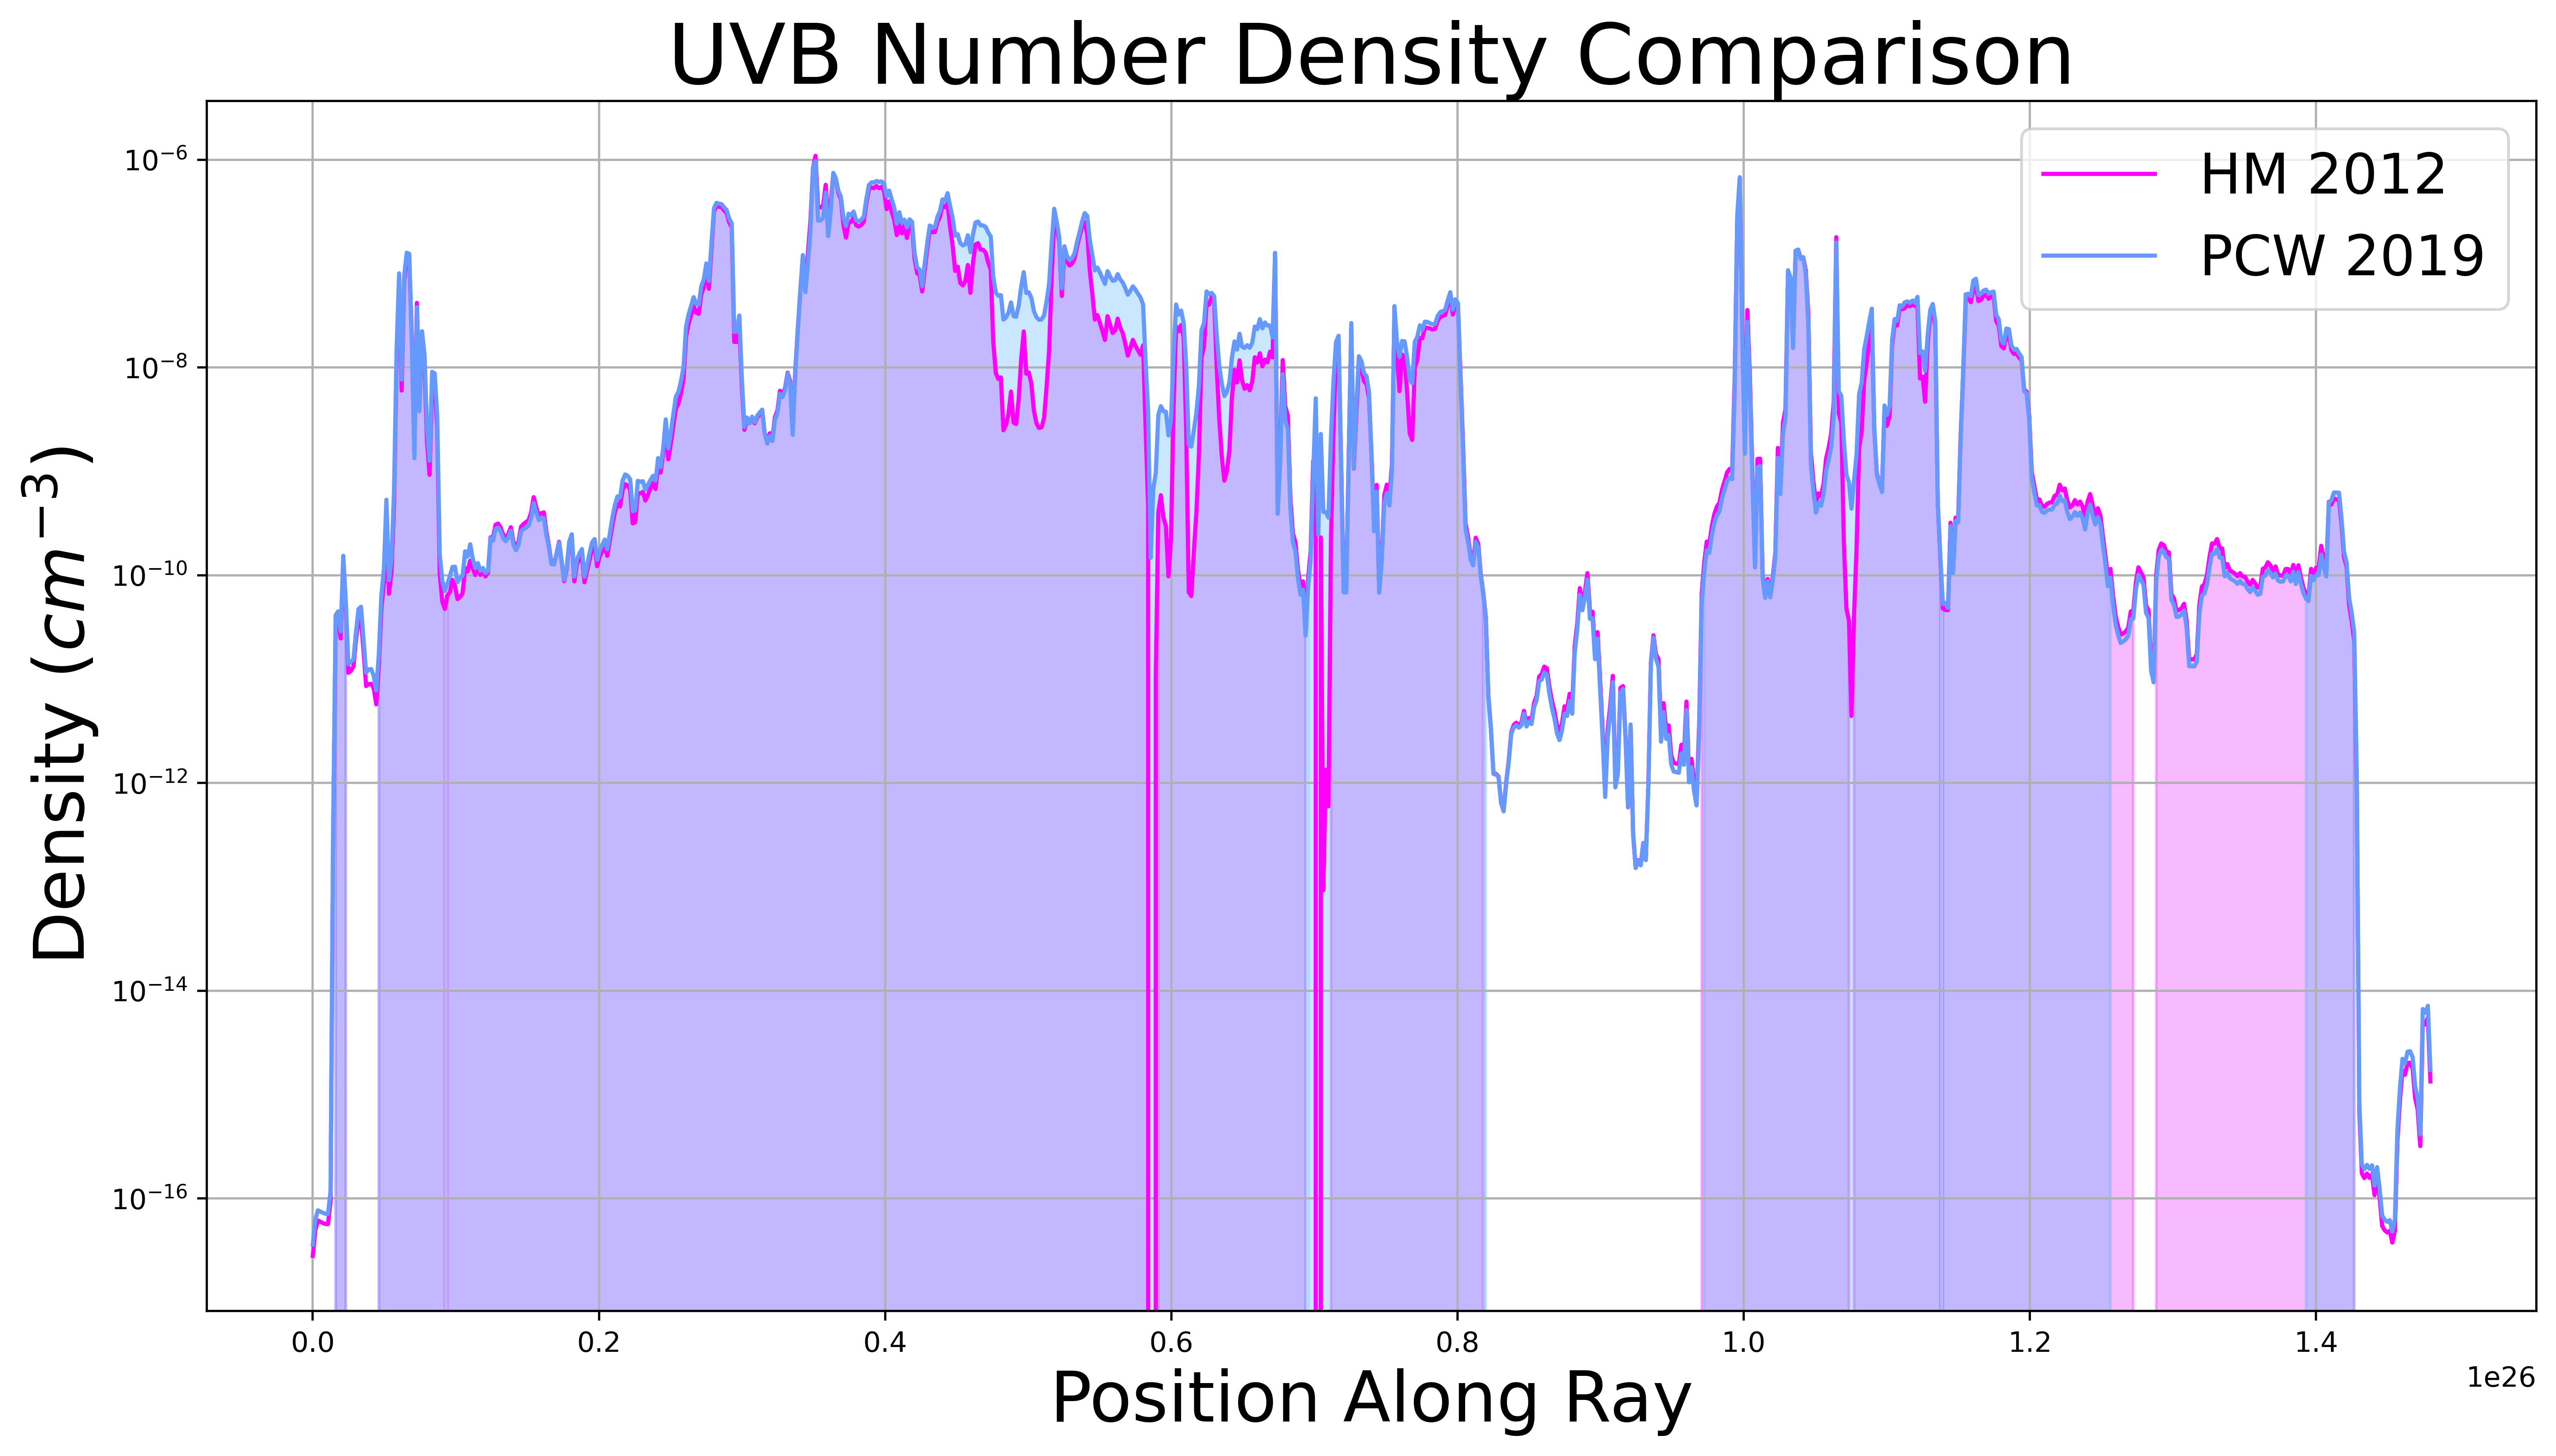

In [13]:
colors = plt.cm.cool([0.3,0.4,0.9,1])

# creating density curves for both UVB models
plt.figure(figsize = [15,8], dpi = 500, facecolor = "white")
plt.semilogy(ray_pos, hm_dens,label = "HM 2012", color = colors[3])
plt.semilogy(ray_pos, pcw_dens,label = "PCW 2019", color = colors[1])
# plt.axhline(1e-13)

hm_clumps = hm_clump_dat[ion]["HM_2012"][hm_clump_dat[ion]["HM_2012"]["lightray_index"] == str(ray)]
pcw_clumps = pcw_clump_dat[ion]["PCW_2019"][pcw_clump_dat[ion]["PCW_2019"]["lightray_index"] == str(ray)]

# showing where SALSA detected clumps in Haart & Madau
i = 0
for i in range(len(hm_clumps["interval_start"])):
    
    lb = hm_clumps["interval_start"][i]
    hb = hm_clumps["interval_end"][i]
    rng = [lb,hb]
    
    yb = hm_dens[slice(*rng)]
    xb = ray_pos[lb:hb]
    
    plt.fill_between(xb,yb, color = colors[2], alpha = 0.3)

# showing where SALSA detected clumps in Puchwein et al
for i in range(len(pcw_clumps["interval_start"])):
    
    lb = pcw_clumps["interval_start"][i]
    hb = pcw_clumps["interval_end"][i]
    
    rng = [lb,hb]
    yb = pcw_dens[slice(*rng)]
    xb = ray_pos[lb:hb]
    
    plt.fill_between(xb,yb, color = colors[0], alpha = 0.3)    

plt.grid()
plt.legend(fontsize = 20)
# plt.ylim(10**(-15),10**(-6.5))
# plt.xlim(500,900)
plt.xlabel("Position Along Ray", fontsize = 25)
plt.ylabel(r"Density ($cm^{-3}$)", fontsize = 25)
plt.title(f"UVB Number Density Comparison", fontsize = 30)
plt.savefig("UVB_issues.pdf")

Here, the purple regions represent where SALSA found a clump in both UVBs and the pink and blue regions represent where SALSA only recognized a clump in 1 of these regions

### Highlighting Issues